# Oxford Pets - Multiclass Segmentation

## Modules

In [ ]:
import os
import sys

common_dir = os.path.abspath("../../common")
print(os.listdir(common_dir))

if common_dir not in sys.path:
    sys.path.append(common_dir)

In [ ]:
import torch
import torch.nn as nn
import torchvision

import random
import numpy as np
import matplotlib.pyplot as plt

from utils import show_images, plot_progress
from pt_trainer import TrainerWithMetrics, TrainerWithEarlyStopping
from pt_trainer import accuracy, binary_accuracy
from scipy.special import softmax, expit as sigmoid

## Parameters

In [ ]:
use_cpu = False
use_cuda = not use_cpu and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

seed = 42
random.seed(seed)
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed_all(seed)

In [ ]:
image_size = (224, 224)
batch_size = 30

In [ ]:
save_weights = False
weights_name = "./pt_models/pt_oxford-pets_seg-3_unet.pth"

## Data Set

In [ ]:
from glob import glob
import re
from sklearn.preprocessing import LabelEncoder
from collections import Counter

def get_paths(image_dir, formats=["*"]):
    invalid_images = ['Egyptian_Mau_14',  'Egyptian_Mau_139', 'Egyptian_Mau_145',
                      'Egyptian_Mau_156', 'Egyptian_Mau_167', 'Egyptian_Mau_177',
                      'Egyptian_Mau_186', 'Egyptian_Mau_191', 'Abyssinian_5',
                      'Abyssinian_34',    'chihuahua_121',    'beagle_116']
    paths = []
    for ext in formats:
        paths += glob(os.path.join(image_dir, f"*.{ext}"))

    valid_paths = []
    for path in paths:
        image_name = os.path.basename(path).split('.')[0]
        if image_name not in invalid_images:
            valid_paths.append(path)
    return valid_paths


def get_labels(image_paths, n_classes=37):
    image_names = [os.path.basename(path).split('.')[0] for path in image_paths]
    if n_classes == 2:
        labels = ['cat' if name[0].isupper() else 'dog' for name in image_names]
    else:
        labels = [re.sub('_\d+', '', name) for name in image_names]
    return labels

def get_class_names(labels):
    return list(Counter(labels).keys())

def label_encoder(labels, class_names):
    encoder = {name: i for i, name in enumerate(class_names)}
    return [encoder[label] for label in labels]

In [ ]:
def change_paths(new_dir, old_paths, replace=("ext1", "ext2")):
    filenames = [os.path.basename(path).replace(replace[0], replace[1])
                 for path in old_paths]
    return [os.path.join(new_dir, name) for name in filenames]

In [ ]:
data_dir = "/mnt/f/deep_learning/datasets/oxford_pets_783M/"
image_dir = os.path.join(data_dir, "images")
mask_dir = os.path.join(data_dir, "annotations", "trimaps")

image_paths = get_paths(image_dir, formats=['jpg'])
labels = get_labels(image_paths, n_classes=37)
class_names = get_class_names(labels)
labels = label_encoder(labels, class_names)

print(f">> Images: {len(image_paths)}")
print(">> Class Names:", class_names)

In [ ]:
from sklearn.model_selection import train_test_split

train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, stratify=labels, train_size=0.8, random_state=seed)

train_image_paths, valid_image_paths, train_labels, valid_labels = train_test_split(
    train_image_paths, train_labels, stratify=train_labels, train_size=0.75, random_state=seed)

train_mask_paths = change_paths(mask_dir, train_image_paths, replace=['jpg', 'png'])
valid_mask_paths = change_paths(mask_dir, valid_image_paths, replace=['jpg', 'png'])
test_mask_paths = change_paths(mask_dir, test_image_paths, replace=['jpg', 'png'])

n_images = len(image_paths)
print(f">> Train images: {len(train_image_paths)} ({len(train_image_paths)/n_images:.2f})")
print(f">> Valid images: {len(valid_image_paths)} ({len(valid_image_paths)/n_images:.2f})")
print(f">> Test  images: {len(test_image_paths)} ({len(test_image_paths)/n_images:.2f})")

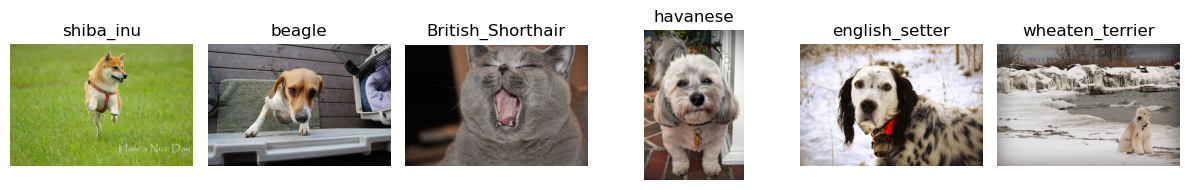

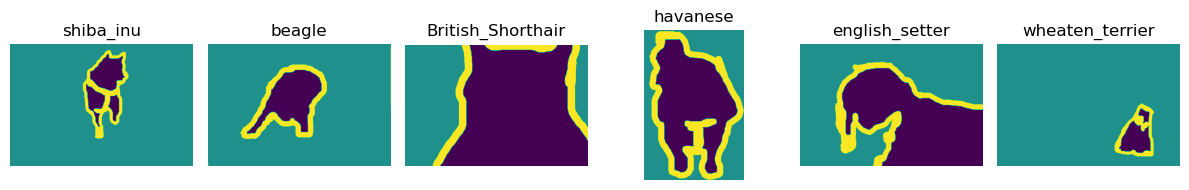

In [10]:
n_samples = 6
show_images(train_image_paths[:n_samples], labels=train_labels[:n_samples], 
            class_names=class_names, n_cols=6)
show_images(train_mask_paths[:n_samples], labels=train_labels[:n_samples], 
            class_names=class_names, n_cols=6)

## Data Loader

In [11]:
import cv2
import albumentations as A

class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, mask_paths, training=False):
        super().__init__()
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = train_transform if training else valid_transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
       
        transformed = self.transform(image=image, mask=mask)
        image = transformed["image"]
        mask = transformed["mask"]
        
        image = torch.tensor(image).permute(2, 0, 1).float()/255 # [0, 255] -> [0, 1]
        mask -= 1
        mask = torch.tensor(mask).long()
        return image, mask


train_transform = A.Compose([
    A.Resize(height=image_size[0], width=image_size[1]),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5, shift_limit=0.05, scale_limit=0.05, rotate_limit=15,),
    A.CoarseDropout(p=0.5, max_holes=8, max_height=int(0.1*image_size[0]), 
                    max_width=int(0.1*image_size[1])),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
valid_transform = A.Compose([
    A.Resize(height=image_size[0], width=image_size[1]),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

train_loader = torch.utils.data.DataLoader(
        Dataset(train_image_paths, train_mask_paths, training=True), 
        batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(
        Dataset(valid_image_paths, valid_mask_paths, training=False), 
        batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
        Dataset(test_image_paths, test_mask_paths, training=False), 
        batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

<class 'torch.Tensor'> torch.Size([30, 3, 224, 224]) torch.float32
<class 'torch.Tensor'> torch.Size([30, 224, 224]) torch.int64
>> Images: min: 0.0, max: 1.0
>> Labels: min: 0, max: 2


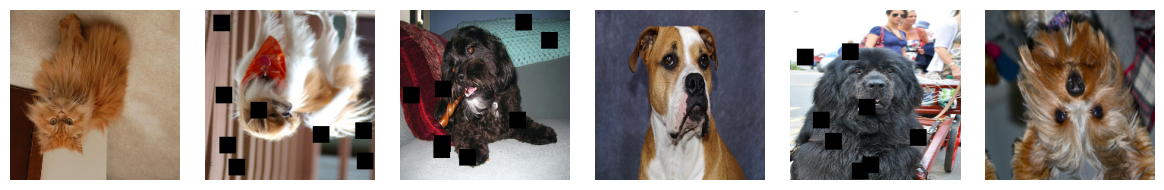

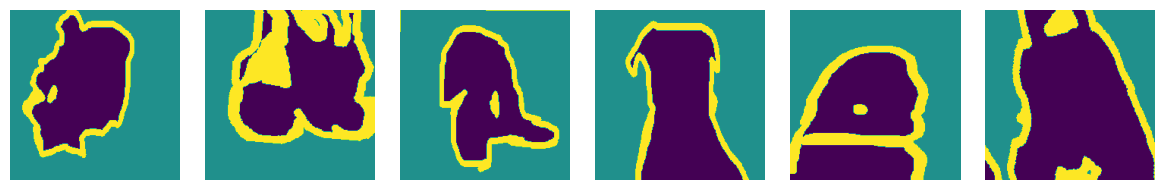

In [12]:
images, masks = next(iter(train_loader))
print(type(images), images.shape, images.dtype)
print(type(masks), masks.shape, masks.dtype)

images = images.permute(0, 2, 3, 1).numpy()
masks = masks.numpy()

n_samples = 6
print(f">> Images: min: {images.min()}, max: {images.max()}")
print(f">> Labels: min: {masks.min()}, max: {masks.max()}")

show_images(images[:n_samples], n_cols=n_samples)
show_images(masks[:n_samples], n_cols=n_samples)

### Modeling

In [13]:
# print(torch.__version__)
# print(torchvision.__version__)
# dir(torchvision.models)

In [14]:
# !pip install segmentation-models-pytorch

In [18]:
import segmentation_models_pytorch as smp

unet = smp.Unet(encoder_name='mobilenet_v2', encoder_weights='imagenet',
                in_channels=3, classes=3)

In [19]:
from pt_trainer import iou, dice_coeff, MulticlassIOU, MulticlassDiceCoeff

def ce_dice_loss(y_pred, y_true):
    ce_loss = nn.CrossEntropyLoss()(y_pred, y_true)
    dice_coeff = MulticlassDiceCoeff(n_classes=4)
    dice_loss = 1 - dice_coeff(y_pred, y_true)
    return ce_loss + dice_loss

In [21]:
x = torch.randn(1, 3, 224, 224)
out = unet(x)

out.shape

torch.Size([1, 3, 224, 224])

## Training

In [22]:
%%time
model = unet.to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = ce_dice_loss
metrics={'dice': MulticlassDiceCoeff(n_classes=4),
         'iou': MulticlassIOU(n_classes=4),
         'acc': accuracy}

clf = TrainerWithEarlyStopping(model, optimizer, loss_fn, metrics)
hist = clf.fit(train_loader, n_epochs=5, valid_loader=valid_loader)

results = clf.evaluate(test_loader)
print(">>", ', '.join([f"test_{key}={value:.4f}" for key, value in results.items()]))

Epoch[  1/  5] loss=0.9194, dice=0.4694, iou=0.3952, acc=0.8504 | val_loss=0.7336, val_dice=0.5314, val_iou=0.4599, val_acc=0.9023 (1)
Epoch[  2/  5] loss=0.7511, dice=0.5227, iou=0.4494, acc=0.8953 | val_loss=0.7249, val_dice=0.5305, val_iou=0.4595, val_acc=0.9068 (1)
Epoch[  3/  5] loss=0.7256, dice=0.5314, iou=0.4597, acc=0.9012 | val_loss=0.6788, val_dice=0.5471, val_iou=0.4792, val_acc=0.9130 (1)
Epoch[  4/  5] loss=0.7099, dice=0.5358, iou=0.4650, acc=0.9049 | val_loss=0.6848, val_dice=0.5472, val_iou=0.4790, val_acc=0.9123 (2)
Epoch[  5/  5] loss=0.6942, dice=0.5410, iou=0.4717, acc=0.9094 | val_loss=0.6963, val_dice=0.5404, val_iou=0.4709, val_acc=0.9113 (3)
>> test_loss=0.6896, test_dice=0.5452, test_iou=0.4770, test_acc=0.9117                             
CPU times: user 2min 19s, sys: 48.4 s, total: 3min 8s
Wall time: 3min 21s


In [ ]:
# if save_weights:
#     torch.save(model, weights_name)

## Inference

In [ ]:
# if save_weights:
#     model = CustomUnet(in_channels=3, out_channels=3).to(device)
#     model.load_state_dict(torch.load(weights_name))

>> Ground Truth:


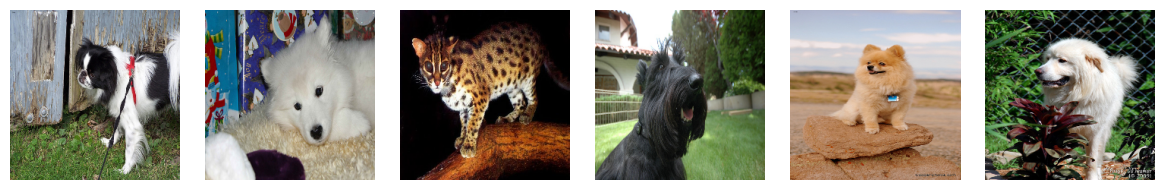

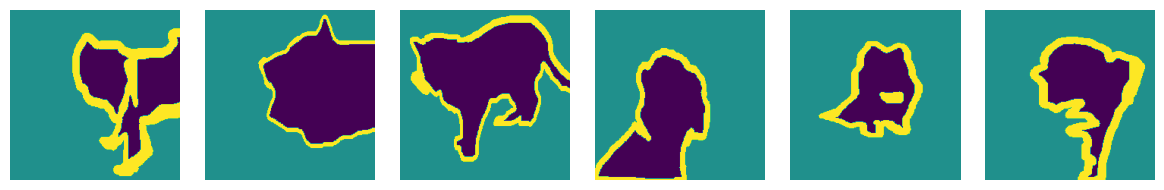

>> Predictions:


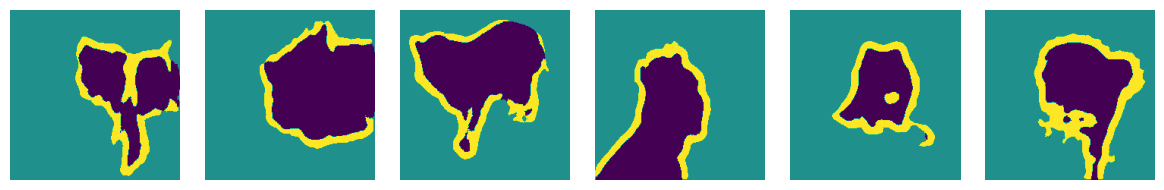

In [23]:
images, masks = next(iter(test_loader))

model.eval()
preds = model(images.to(device)).detach().cpu()

images = images.permute(0, 2, 3, 1).numpy()
masks = masks.numpy()
preds = softmax(preds.numpy()).argmax(axis=1)

n_samples = 6
print(">> Ground Truth:")
show_images(images[:n_samples], n_cols=n_samples)
show_images(masks[:n_samples], n_cols=n_samples)

print(">> Predictions:")
show_images(preds[:n_samples], n_cols=n_samples)